<a href="https://colab.research.google.com/github/burakbeyazit/grad-project/blob/main/Bitirme_Projem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Dosya yolu
file_path = '/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv'

# Dosyayı oku
df = pd.read_csv(file_path)

# Ön temizlik: eksik verileri sil
df_clean = df.dropna().copy()

# Koordinat düzeltme fonksiyonu
def fix_coordinate(value):
    try:
        if pd.isna(value):
            return None
        if isinstance(value, str) and value.startswith("."):
            value = "0" + value
        value = float(value)
        if abs(value) > 180:
            value /= 100000
        return round(value, 6)
    except:
        return None

# Latitude ve Longitude sütunlarını temizle
df_clean["Latitude"] = df_clean["Latitude"].apply(fix_coordinate)
df_clean["Longitude"] = df_clean["Longitude"].apply(fix_coordinate)

# Hatalı koordinatları tamamen sil
df_clean = df_clean.dropna(subset=["Latitude", "Longitude"])

# Dosyayı tekrar kaydet
df_clean.to_csv(file_path, index=False)

print("Dosya eksiksiz ve temiz olarak güncellendi.")


Dosya eksiksiz ve temiz olarak güncellendi.


In [1]:
import pandas as pd
import math

# 1) Dosya yolları
filed_path   = '/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv'
actual_path  = '/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv'
flights_meta = '/content/drive/MyDrive/Flight_Datas/Flights_20220601_20220630.csv'

# 2) Verileri oku
df_filed  = pd.read_csv(filed_path)
df_actual = pd.read_csv(actual_path)
df_meta   = pd.read_csv(flights_meta)

df_meta = df_meta[["ECTRL ID", "ADEP", "ADES"]]

# Ekleme işlemleri (ECTRL ID üzerinden)
df_actual = df_actual.merge(df_meta, on="ECTRL ID", how="left")
df_filed = df_filed.merge(df_meta, on="ECTRL ID", how="left")

# Kontrol
print("Actual örnek:")
print(df_actual.head())

print("\nFiled örnek:")
print(df_filed.head())


Actual örnek:
    ECTRL ID  Sequence Number            Time Over  Flight Level  Latitude  \
0  252119478                0  31-05-2022 23:50:00             0  51.88500   
1  252119478                1  01-06-2022 00:02:00             0  51.88500   
2  252119478                2  01-06-2022 00:03:25            29  51.83500   
3  252119478                3  01-06-2022 00:04:15            50  51.85833   
4  252119478                4  01-06-2022 00:04:52            66  51.90750   

   Longitude  ADEP  ADES  
0    0.23500  EGSS  EGAA  
1    0.23500  EGSS  EGAA  
2    0.16056  EGSS  EGAA  
3    0.09750  EGSS  EGAA  
4    0.08195  EGSS  EGAA  

Filed örnek:
    ECTRL ID  Sequence Number            Time Over  Flight Level  Latitude  \
0  252119478                0  01-06-2022 00:00:00             0  51.88500   
1  252119478                1  01-06-2022 00:15:00             0  51.88500   
2  252119478                2  01-06-2022 00:16:15            36  51.83500   
3  252119478                3

✅ Eğitim verisi boyutu  : 8246 satır
✅ Test verisi boyutu    : 2062 satır
✅ Toplam uçuş sayısı    : 300 adet

📊 Model Performansı (Test seti üzerinde):
🔹 MAE   : 38.47 km
🔹 RMSE  : 68.60 km
🔹 R²    : 0.959

🛫 ADEP / ADES Bilgili Karşılaştırma (ilk 10 satır):
   ADEP_actual ADES_actual  Actual Deviation (km)  Predicted Deviation (km)
0         LTAI        LTFM              54.249821                 51.680472
1         UTAA        EDDF             303.218039                302.887957
2         EGNX        EGAA              24.539810                 24.312213
3         EGPE        EGLL             294.787222                357.024636
4         LIEA        LIRP              16.992604                 28.102169
5         KBOS        EDDM               0.000000                 25.843064
6         EDDL        LGIR              89.176156                 95.931489
7         EDDK        LTFJ               0.000000                  0.697421
8         KDFW        EGLL             334.422020        

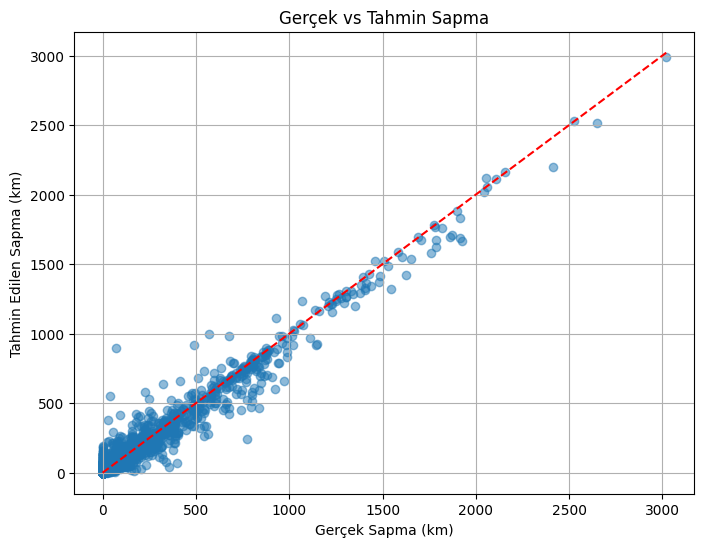

In [9]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 1. Verileri yükle ===
actual_df = pd.read_csv('/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv')
filed_df = pd.read_csv('/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv')
meta_df = pd.read_csv("/content/drive/MyDrive/Flight_Datas/Flights_20220601_20220630.csv")[["ECTRL ID", "ADEP", "ADES"]]

# === 2. İlk 300 uçuşu filtrele ===
sample_ids = actual_df["ECTRL ID"].drop_duplicates().head(300)
actual_df = actual_df[actual_df["ECTRL ID"].isin(sample_ids)]
filed_df = filed_df[filed_df["ECTRL ID"].isin(sample_ids)]

# === 3. Merge actual + filed ===
merged_df = actual_df.merge(
    filed_df,
    on=["ECTRL ID", "Sequence Number"],
    suffixes=("_actual", "_filed"),
    how="inner"
)

# === 4. Sapma hesabı için Haversine ===
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 6371 * 2 * asin(sqrt(a))

merged_df["deviation_km"] = merged_df.apply(lambda row: haversine(
    row["Latitude_actual"], row["Longitude_actual"],
    row["Latitude_filed"], row["Longitude_filed"]
), axis=1)

# === 5. Meta bilgilerini merge et (ADEP/ADES) ===
merged_df = merged_df.merge(meta_df, on="ECTRL ID", how="left")
merged_df.rename(columns={"ADEP": "ADEP_actual", "ADES": "ADES_actual"}, inplace=True)

# === 6. Feature + target ===
features = merged_df[[
    "Latitude_filed", "Longitude_filed", "Flight Level_filed",
    "Latitude_actual", "Longitude_actual", "Flight Level_actual"
]]
target = merged_df["deviation_km"]

# === 7. Train-Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

print(f"✅ Eğitim verisi boyutu  : {X_train.shape[0]} satır")
print(f"✅ Test verisi boyutu    : {X_test.shape[0]} satır")
print(f"✅ Toplam uçuş sayısı    : {merged_df['ECTRL ID'].nunique()} adet")

# === 8. Model eğitimi ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 9. Test verisinde tahmin ===
y_pred = model.predict(X_test)

# === 10. Performans değerlendirme ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Performansı (Test seti üzerinde):")
print(f"🔹 MAE   : {mae:.2f} km")
print(f"🔹 RMSE  : {rmse:.2f} km")
print(f"🔹 R²    : {r2:.3f}")

# === 11. Gerçek ve tahmin karşılaştırma tablosu ===
compare_df = X_test.copy()
compare_df["Actual Deviation (km)"] = y_test.values
compare_df["Predicted Deviation (km)"] = y_pred

# === 12. ECTRL ID'leri eşleştir ===
compare_df["ECTRL ID"] = y_test.index.map(lambda idx: merged_df.iloc[idx]["ECTRL ID"])

# === 13. ADEP / ADES merge et ===
compare_df = compare_df.merge(
    merged_df[["ECTRL ID", "ADEP_actual", "ADES_actual"]].drop_duplicates(),
    on="ECTRL ID",
    how="left"
)

# === 14. İlk 10 satırı göster ===
print("\n🛫 ADEP / ADES Bilgili Karşılaştırma (ilk 10 satır):")
print(compare_df[[
    "ADEP_actual", "ADES_actual",
    "Actual Deviation (km)", "Predicted Deviation (km)"
]].head(50))

# === 15. Scatter plot ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, max(y_test.max(), y_pred.max())], [0, max(y_test.max(), y_pred.max())], 'r--')
plt.xlabel("Gerçek Sapma (km)")
plt.ylabel("Tahmin Edilen Sapma (km)")
plt.title("Gerçek vs Tahmin Sapma")
plt.grid(True)
plt.show()
